<a href="https://colab.research.google.com/github/petaykina/apetaykina/blob/main/apetaykina_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive 
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!pip install numpy scipy patsy pandas --upgrade
!pip install statsmodels --upgrade
!pip install scikit_posthocs pingouin --upgrade

In [1]:
!pip install matplotlib --upgrade
import matplotlib
matplotlib.__version__

'3.6.2'

In [2]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import scikit_posthocs as sp
import scipy.stats as stats
import pingouin as pg
import statsmodels.api as sm
from statsmodels.formula.api import ols

sns.set_theme()
sns.set(style="whitegrid")

# Сценарий
Сеть ресторанов быстрого питания планирует добавить в свое меню новый пункт. Однако они до сих пор не определились между тремя возможными маркетинговыми кампаниями по продвижению нового продукта. Чтобы определить, какая рекламная акция оказывает большее влияние на продажи, новый товар выставляется в точках на нескольких случайно выбранных рынках. В каждом магазине используется отдельная акция, и еженедельные продажи нового товара регистрируются в течение первых четырех недель.

###Цель
Провести исследовательский анализ даннаых, параметрический тест Шапиро-Уилкса на нормальность, тест Левена на однородность дисперсии и непараметрический тест Крускала-Уолиса.

###Выводы
1. Всего было проведено 517 рекламных акций на всех рынках, 172 с типом продвижения 1, 188 с типом продвижения 2 и типом 3 соответственно.
2. Общее количество внедрений каждой рекламной акции для каждого размера рынка (размера выборки) не одинаково, но похоже.
3. По-видимому, существует среднее и медианное различие между типами продвижения на каждом рынке, а также на всех рынках вместе взятых.
4. Тест Шапиро-Уилкаса отклонил нормальность в случаях "Все рынки" и "Большой рынок"
5. Тест Левена на однородность дисперсии показал примерно равные отклонения для всех групп.
6. Согласно тесту Крускала-Уолиса существует значительная разница во влиянии каждого типа продвижения на выручку от продаж в зависимости от размера рынка

###Столбцы
MarketID: уникальный идентификатор рынка

MarketSize: объемы рынка по продажам

LocationID: уникальный идентификатор местоположения магазина

AgeOfStore: возраст магазина в годах.

Promotion: одна из трех промо-акций, которые были протестированы.

Week: одна из четырех недель, когда проводились акции

SalesInThousands: сумма продаж для определенного LocationID, промоакции и недели.

# Загрузка данных

In [3]:
df = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/WA_Marketing-Campaign.csv')

In [4]:
df.head()

,MarketID,MarketSize,LocationID,AgeOfStore,Promotion,week,SalesInThousands
0,1,Medium,1,4,3,1,33.73
1,1,Medium,1,4,3,2,35.67
2,1,Medium,1,4,3,3,29.03
3,1,Medium,1,4,3,4,39.25
4,1,Medium,2,5,2,1,27.81


## Очистка данных

In [12]:
df.describe()

,MarketID,LocationID,AgeOfStore,Promotion,week,SalesInThousands
count,548.000000,548.000000,548.000000,548.000000,548.000000,548.000000
mean,5.715328,479.656934,8.503650,2.029197,2.500000,53.466204
std,2.877001,287.973679,6.638345,0.810729,1.119055,16.755216
min,1.000000,1.000000,1.000000,1.000000,1.000000,17.340000
25%,3.000000,216.000000,4.000000,1.000000,1.750000,42.545000
50%,6.000000,504.000000,7.000000,2.000000,2.500000,50.200000
75%,8.000000,708.000000,12.000000,3.000000,3.250000,60.477500
max,10.000000,920.000000,28.000000,3.000000,4.000000,99.650000


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 548 entries, 0 to 547
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   MarketID          548 non-null    int64  
 1   MarketSize        548 non-null    object 
 2   LocationID        548 non-null    int64  
 3   AgeOfStore        548 non-null    int64  
 4   Promotion         548 non-null    int64  
 5   week              548 non-null    int64  
 6   SalesInThousands  548 non-null    float64
dtypes: float64(1), int64(5), object(1)
memory usage: 30.1+ KB


In [14]:
df.isna().sum()

MarketID            0
MarketSize          0
LocationID          0
AgeOfStore          0
Promotion           0
week                0
SalesInThousands    0
dtype: int64

In [15]:
df.duplicated().sum()

0

Отсутствующих данных и дубликатов не обнаружено.

# Исследовательский анализ данных

In [16]:
df.nunique()

MarketID             10
MarketSize            3
LocationID          137
AgeOfStore           25
Promotion             3
week                  4
SalesInThousands    517
dtype: int64

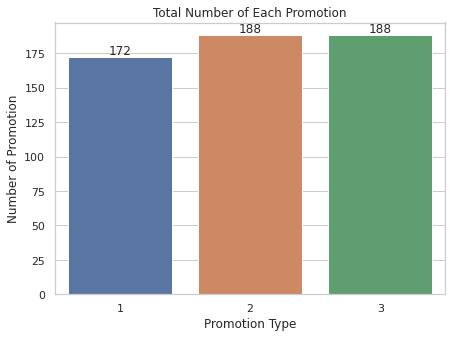

In [5]:
df_all_market= df.groupby('Promotion').size().to_frame().reset_index()
df_all_market.rename(columns={0: 'n_promo'}, inplace=True)

plt.figure(figsize=(7,5))
ax = sns.barplot(x='Promotion',y='n_promo', data=df_all_market)
ax.bar_label(ax.containers[0])
plt.xlabel("Promotion Type")
plt.ylabel("Number of Promotion")
plt.title("Total Number of Each Promotion")
plt.show()

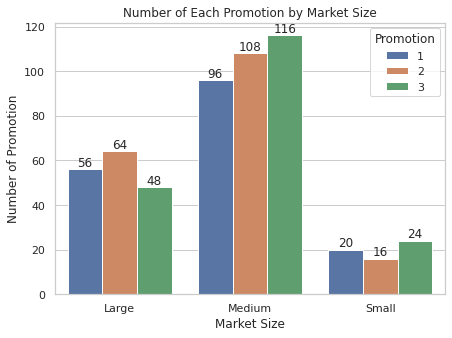

In [6]:
df_marketsize = df.groupby(['MarketSize', 'Promotion']).size().to_frame().reset_index()
df_marketsize.rename(columns={0: 'n_promo'}, inplace=True)

plt.figure(figsize=(7,5))
ax = sns.barplot(x='MarketSize', y='n_promo',hue='Promotion', data=df_marketsize)
for container in ax.containers:
    ax.bar_label(container)
plt.title("Number of Each Promotion by Market Size")
plt.xlabel("Market Size")
plt.ylabel("Number of Promotion")
plt.show()

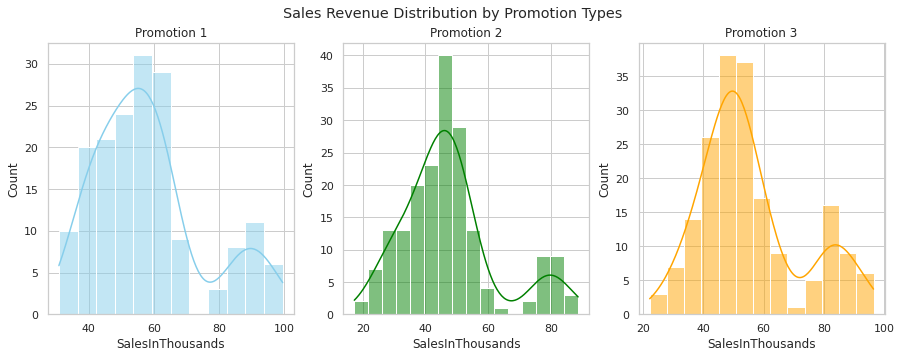

In [19]:
promo1 = df.loc[df['Promotion'] == 1]
promo2 = df.loc[df['Promotion'] == 2]
promo3 = df.loc[df['Promotion'] == 3]

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

sns.histplot(data=promo1, x="SalesInThousands", kde=True, color="skyblue", ax=axs[0])
sns.histplot(data=promo2, x="SalesInThousands", kde=True, color="green", ax=axs[1])
sns.histplot(data=promo3, x="SalesInThousands", kde=True, color="orange", ax=axs[2])

axs[0].set_title("Promotion 1")
axs[1].set_title("Promotion 2")
axs[2].set_title("Promotion 3")
fig.suptitle("Sales Revenue Distribution by Promotion Types")
plt.show()

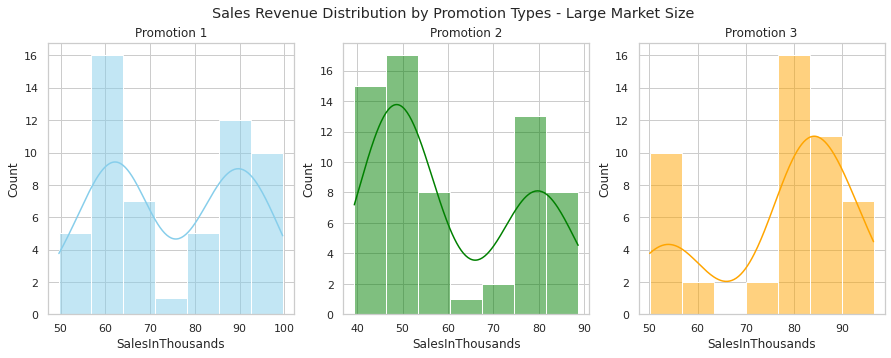

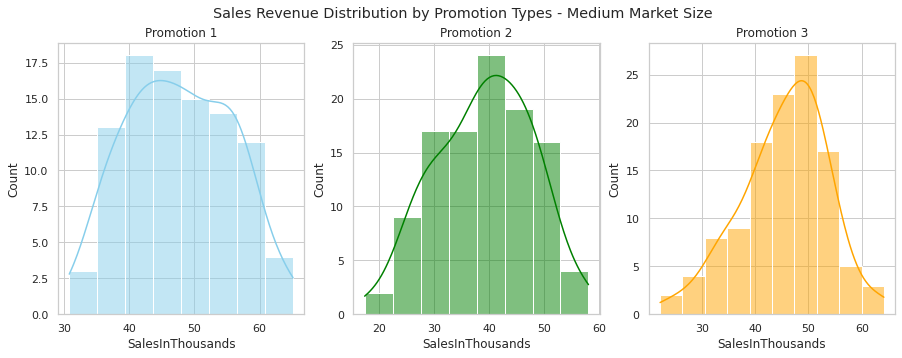

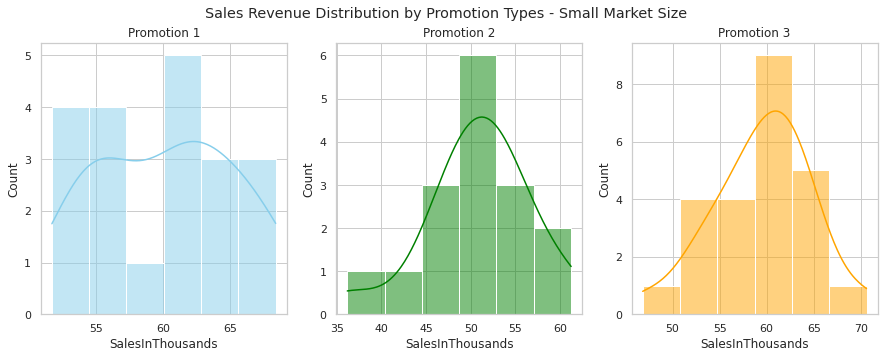

In [20]:
sizes = ['Large', 'Medium', 'Small']
for size in sizes:
    temp = df.loc[df['MarketSize'] == size]
    promo1 = temp.loc[df['Promotion'] == 1]
    promo2 = temp.loc[df['Promotion'] == 2]
    promo3 = temp.loc[df['Promotion'] == 3]

    fig, axs = plt.subplots(1, 3, figsize=(15, 5))

    sns.histplot(data=promo1, x="SalesInThousands", kde=True, color="skyblue", ax=axs[0])
    sns.histplot(data=promo2, x="SalesInThousands", kde=True, color="green", ax=axs[1])
    sns.histplot(data=promo3, x="SalesInThousands", kde=True, color="orange", ax=axs[2])

    axs[0].set_title("Promotion 1")
    axs[1].set_title("Promotion 2")
    axs[2].set_title("Promotion 3")
    fig.suptitle("Sales Revenue Distribution by Promotion Types - {} Market Size".format(size))
    plt.show()

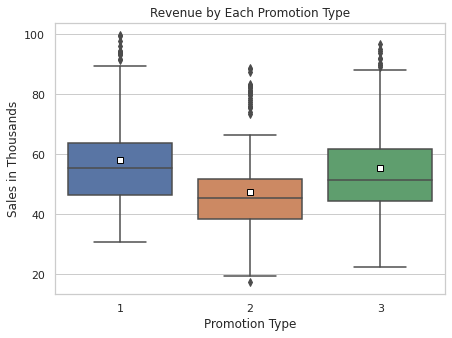

In [21]:
fig= plt.figure(figsize=(7,5))
ax = sns.boxplot(y="SalesInThousands", data=df, x='Promotion', showmeans=True, 
                 meanprops={"marker":"s", "markerfacecolor":"white", 
                            "markeredgecolor":"black"})
plt.ylabel('Sales in Thousands')
plt.xlabel('Promotion Type')
plt.title('Revenue by Each Promotion Type')
plt.show()

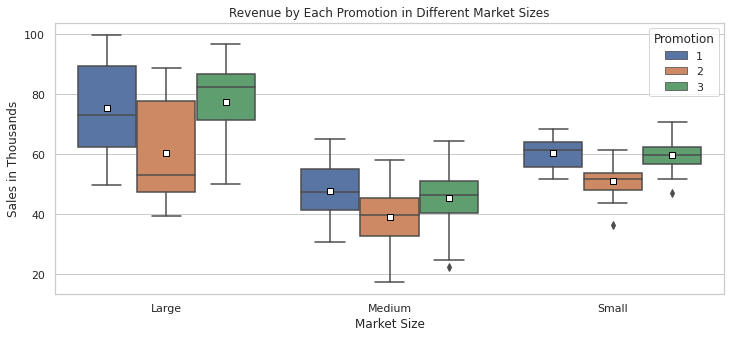

In [22]:
plt.figure(figsize=(12,5))
sns.boxplot(x="MarketSize", y="SalesInThousands", hue="Promotion", data=df, 
            order=['Large','Medium','Small'], showmeans=True, 
            meanprops={"marker":"s","markerfacecolor":"white", 
                       "markeredgecolor":"black"})
plt.title('Revenue by Each Promotion in Different Market Sizes')
plt.xlabel('Market Size')
plt.ylabel('Sales in Thousands')
plt.show()

# Резюме

1.   Всего было проведено 517 рекламных акций на всех рынках, 172 с типом продвижения 1, 188 с типом продвижения 2 и типом 3 соответственно.
2.   Общее количество внедрений каждой рекламной акции для каждого размера рынка (размера выборки) не одинаково, но похоже.
3. По-видимому, существует среднее и медианное различие между типами продвижения на каждом рынке, а также на всех рынках вместе взятых.

# Проверка предположений Однофакторного дисперсионного анализа (ANOVA) 
###*Предположения:*
1. Независимость: все группы являются взаимоисключающими, и данные не являются повторными измерениями.

2. Нормальность: ответы для каждого уровня фактора имеют нормальное распределение популяции.

3. Однородность дисперсии: дисперсия среди групп должна быть примерно одинаковой


## 1. Проверка нормальности: тест Шапиро-Уилка и QQ-график.

*Нулевая гипотеза*: переменная нормально распределена.

*Альтернативная гипотеза:* переменная не имеет нормального распределения.

Функция проверки нормальности и подмножества для каждого размера рынка

In [20]:
def normality(df, size="All Market Combined : "):
    promotion_sort = np.sort(df['Promotion'].unique())
    fig, axes = plt.subplots(1, 3, figsize=(15,7))
                             
    for prom in promotion_sort:
        temp = df.loc[df['Promotion']==prom]
        model = ols('SalesInThousands ~ Promotion', data=temp).fit()
        print("Promotion type", prom, ',', size, stats.shapiro(model.resid))
        
        ax_ind = prom - 1
        sm.qqplot(model.resid, line='s', ax=axes[ax_ind])
        axes[ax_ind].set_title("Probability Plot Residuals - Promotion " + str(prom))
        fig.suptitle(size)
    plt.show()

In [21]:
large_market = df.loc[df['MarketSize'] == 'Large']
medium_market = df.loc[df['MarketSize'] == 'Medium']
small_market = df.loc[df['MarketSize'] == 'Small']

###1) Все рынки

Promotion type 1 , All Market Combined :  ShapiroResult(statistic=0.9152998328208923, pvalue=1.9772498305314912e-08)
Promotion type 2 , All Market Combined :  ShapiroResult(statistic=0.9145088195800781, pvalue=5.456247009760773e-09)
Promotion type 3 , All Market Combined :  ShapiroResult(statistic=0.9207685589790344, pvalue=1.499518376135711e-08)


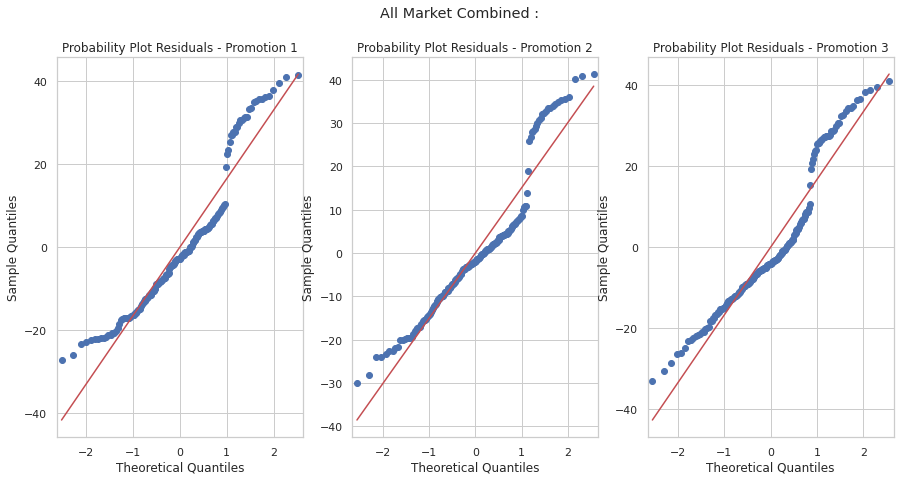

In [22]:
normality(df)

###2) Размер каждого рынка

Promotion type 1 , Large Market :  ShapiroResult(statistic=0.8993790149688721, pvalue=0.00020807083637919277)
Promotion type 2 , Large Market :  ShapiroResult(statistic=0.8425076007843018, pvalue=9.79393803390849e-07)
Promotion type 3 , Large Market :  ShapiroResult(statistic=0.8405065536499023, pvalue=1.2286296623642556e-05)


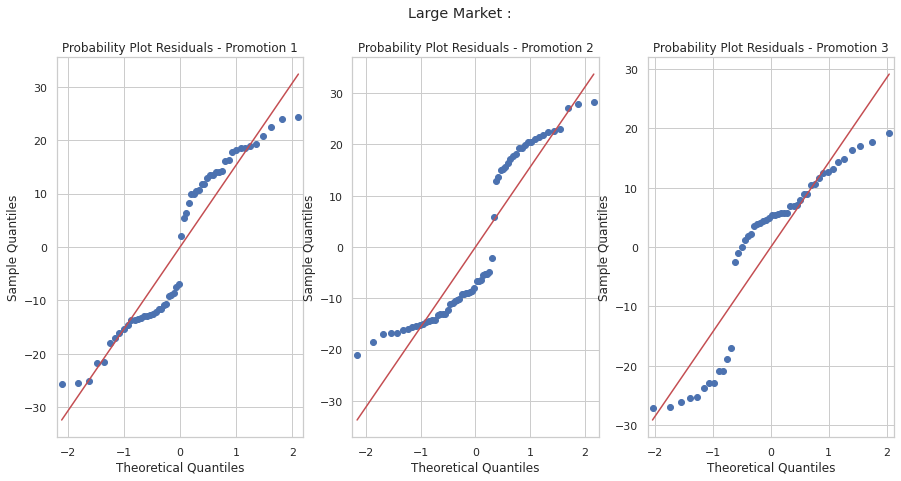

In [23]:
normality(large_market, 'Large Market : ')

Promotion type 1 , Medium Market :  ShapiroResult(statistic=0.978887677192688, pvalue=0.12411894649267197)
Promotion type 2 , Medium Market :  ShapiroResult(statistic=0.9882073998451233, pvalue=0.46653512120246887)
Promotion type 3 , Medium Market :  ShapiroResult(statistic=0.983024001121521, pvalue=0.1506854146718979)


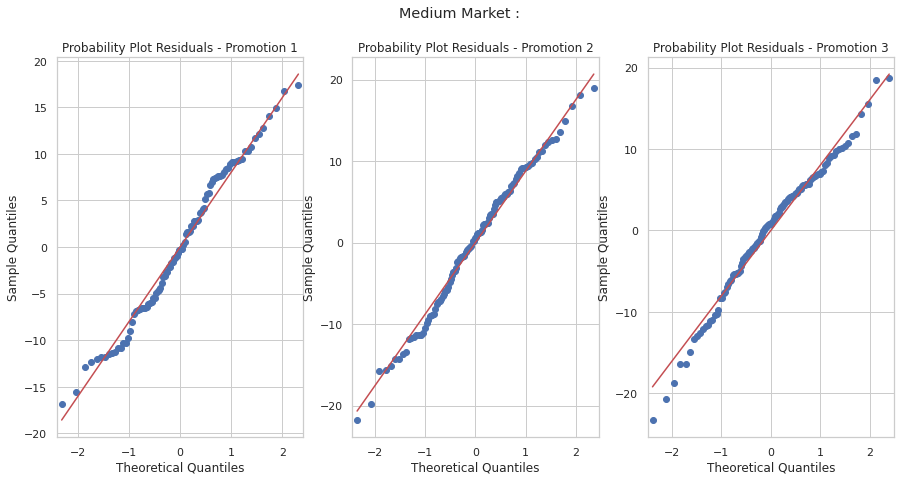

In [28]:
normality(medium_market, 'Medium Market : ')

Promotion type 1 , Small Market :  ShapiroResult(statistic=0.9466673731803894, pvalue=0.3193163573741913)
Promotion type 2 , Small Market :  ShapiroResult(statistic=0.9612026214599609, pvalue=0.6836715340614319)
Promotion type 3 , Small Market :  ShapiroResult(statistic=0.9816325306892395, pvalue=0.9239219427108765)


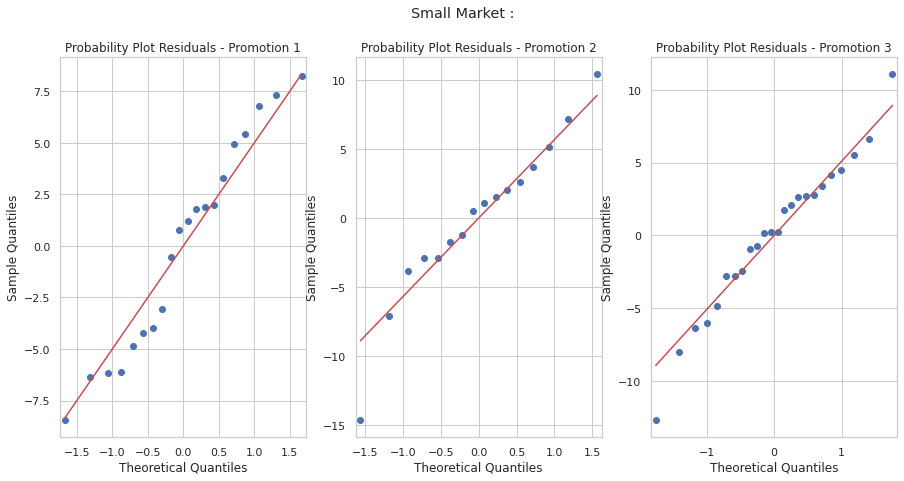

In [29]:
normality(small_market, 'Small Market : ')

## Результат
Нулевая гипотеза Шапиро-Уилкса отвергается в случае всех рекламных акций на всех рынках вместе взятых (Продвижение 1 [p = 1,9772498305314912e-08], Продвижение 2 [p = 5,4563846774158264e-09], Продвижение 3 [p = 1,4994856911698662e-08] ).

Он также отклоняется в случае большого рынка (Акция 1 [p = 0,000208], Акция 2 [p = 9,793707249627914e-07], Акция 3 [p = 1,2286296623642556e-05]).

Графики QQ для этих случаев показали, что они представляют собой скорее бимодальное распределение, чем нормальное.

Таким образом, предположение о нормальности не выполняется для однофакторного Anova.

##2. Проверка однородности дисперсии: тест Левена.

*Нулевая гипотеза:* групповые дисперсии равны

*Альтернативная гипотеза:* групповые дисперсии не равны.

###1) Все рынки

In [7]:
pg.homoscedasticity(df, dv='SalesInThousands', 
                    group='Promotion')

,W,pval,equal_var
levene,1.269679,0.281751,True


###2) По отдельности

In [11]:
pg.homoscedasticity(large_market, dv='SalesInThousands', 
                    group='Promotion')

,W,pval,equal_var
levene,2.19467,0.114637,True


In [12]:
pg.homoscedasticity(medium_market, dv='SalesInThousands', 
                    group='Promotion')

,W,pval,equal_var
levene,0.859706,0.424271,True


In [13]:
pg.homoscedasticity(small_market, dv='SalesInThousands', 
                    group='Promotion')

,W,pval,equal_var
levene,0.063634,0.938415,True


###Результат:
Нулевая гипотеза не отвергается как на всех рынках вместе взятых ((p = 0,281), так и на каждом рынке (большой: p = 0,114637, средний: p = 0,424271, малый = 0,938415).

Группы (типы продвижения) имеют примерно равные отклонения.

 


##Выводы
Нет уверенности в том, что группы в случае "всех рынков" и "большого рынка" взяты из нормального распределения.

Поскольку это может увеличить вероятность ложноположительного результата (тип I, отвергающий истинную нулевую гипотезу), проведем тест Крускала-Уоллиса, который не предполагает определенного распределения, вместо одностороннего ANOVA.

##Тест Крускала-Уоллиса
###Переменные:
1) *Независимая переменная:* продвижение (назначенные группы: тип продвижения 1, тип продвижения 2, тип продвижения 3)

2) *Зависимая переменная:* доход от продаж

##1. Разница в случае "Все рынки"
###Гипотеза:
*Нулевая гипотеза:* средний доход от продаж по крайней мере между двумя типами рекламных акций равен.

*Альтернативная гипотеза:* средний доход от продаж по крайней мере между двумя типами рекламных акций не равен.

In [14]:
pg.kruskal(data=df, dv='SalesInThousands', between='Promotion', detailed=True)

,Source,ddof1,H,p-unc
Kruskal,Promotion,2,53.294752,2.674187e-12


###Результат :
Тест Крускала-Уоллиса был проведен для сравнения влияния трех различных типов рекламных акций на доход от продаж на рынке в целом. Выяснилось, что существовала статистически значимая разница в доходах от продаж как минимум между двумя типами продвижения (H = 53,294, p = 2,674187e-12).

##2. Разница в размере каждого рынка
###Гипотеза:
*Нулевая гипотеза:* средний доход от продаж по крайней мере между двумя типами рекламных акций равен размеру рынка (крупному, среднему, малому).

*Альтернативная гипотеза:* средний доход от продаж по крайней мере между двумя типами рекламных акций не равен размеру рынка (крупному, среднему, малому).

###1. Большой рынок:

In [15]:
pg.kruskal(data=large_market, dv='SalesInThousands', between='Promotion', detailed=True)

,Source,ddof1,H,p-unc
Kruskal,Promotion,2,41.029606,1.231783e-09


###2. Средний рынок

In [16]:
pg.kruskal(data=medium_market, dv='SalesInThousands', between='Promotion', detailed=True)

,Source,ddof1,H,p-unc
Kruskal,Promotion,2,45.669053,1.210852e-10


###3. Малый рынок

In [17]:
pg.kruskal(data=small_market, dv='SalesInThousands', between='Promotion', detailed=True)

,Source,ddof1,H,p-unc
Kruskal,Promotion,2,21.046562,0.000027


##Результат :
Результат такой же, как и в случае всех рынков вместе взятых. Существует значительная разница во влиянии каждого типа продвижения на выручку от продаж в зависимости от размера рынка. (p для большого размера рынка = 1,231783e-09, p для среднего размера рынка = 1,210852e-10, p для малого размера рынка = 0,000027)